In [1]:
from keras.datasets import cifar100    
from models.utils import ResNet18, split_dataframe, detect_drifts
from skimage.transform import resize
import keras
import numpy as np
import models.unmasking_drift_detector as unm
import models.d3_drift_detector as d3
import matplotlib.pyplot as plt
import tensorflow as tf

2024-02-13 16:07:43.943683: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 16:07:43.972239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 16:07:43.972263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 16:07:43.972935: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 16:07:43.977060: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 16:07:43.977396: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
(images_train, labels_train), (images_test, labels_test) = cifar100.load_data()

# svhn_data = loadmat('/home/edstan/Desktop/master_AI/practice/driftDatasets/realWorld/train_32x32.mat')
# svhn_images, svhn_labels = svhn_data['X'], svhn_data['y']
# svhn_images = np.moveaxis(svhn_images, -1, 0)
# cap = svhn_images.shape[0] // 2
# idx = int(0.8 * cap)

In [7]:
train_indices = np.where(np.isin(labels_train, range(50)))[0]
X_train = images_train[train_indices]
y_train = labels_train[train_indices]
test_indices = np.where(np.isin(labels_test, range(50)))[0]
X_test = images_test[test_indices]
y_test = labels_test[test_indices]

In [8]:
model = tf.keras.models.load_model('driftDatasets/model_25epochs.h5')


In [9]:
extract_features_model = keras.Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

In [10]:
unseen_data_indices = np.where(np.isin(labels_train, range(50, 100)))[0]
unseen_data = images_train[unseen_data_indices]
unseen_data.shape

(25000, 32, 32, 3)

In [11]:
from keras.datasets import mnist
(mnist_images, _), (_, _) = mnist.load_data()
mnist_images = resize(mnist_images, (mnist_images.shape[0],32,32,3))

In [12]:
drifted_data = np.empty((0, 32, 32, 3))
i = 0
last_index = 0
current_index = 0
ground_truth_drifts = []

dimension_limit = 0.8 * X_train.shape[0]
while drifted_data.shape[0] < dimension_limit:
    current_index += np.random.choice([200, 400, 600, 800])
    if i % 2 == 0:
        if i != 0:
            ground_truth_drifts.append(drifted_data.shape[0])
        known_batch = X_train[3*last_index:3*current_index]
        drifted_data = np.concatenate((drifted_data, known_batch), axis=0)
    else:
        ground_truth_drifts.append(drifted_data.shape[0])
        known_batch = X_train[2*last_index:2*current_index]
        batch = np.concatenate((known_batch, mnist_images[last_index:current_index]), axis=0)
        np.random.shuffle(batch)
        drifted_data = np.concatenate((drifted_data, batch), axis=0)
    last_index = current_index
    i += 1

In [13]:
features = extract_features_model.predict(drifted_data)
features.shape

2024-02-13 16:09:03.124677: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 250675200 exceeds 10% of free system memory.


638/638 [==============================] - 9s 13ms/step


2024-02-13 16:09:12.844444: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 41779200 exceeds 10% of free system memory.


(20400, 512)

In [14]:
batch_size = 400
data_splitted = split_dataframe(features, batch_size)
ground_truth_drifts_batch = np.array(ground_truth_drifts) / 400
ground_truth_drifts_batch = ground_truth_drifts_batch.astype(int)
ground_truth_drifts_batch

array([ 3,  9, 10, 13, 19, 25, 30, 33, 39, 45])

In [18]:
# Detect drifts using D3 algorithm
print("D3:")
sim_d3 = detect_drifts(data_splitted, d3.drift_detector, ground_truth_drifts_batch, accepted_error=1, show_drifts=True)
print(sim_d3) # 0.5

D3:
Change detected at index 9
Change detected at index 14
Change detected at index 26
Change detected at index 33
Change detected at index 45
0.5


Unmasking:
Threshold = 0.45
0.3125
Threshold = 0.47
0.3448275862068966
Threshold = 0.5
0.37037037037037035
Threshold = 0.52
0.5555555555555556
Threshold = 0.53
0.4666666666666667
Threshold = 0.54
0.5384615384615384
Threshold = 0.55
0.7
Threshold = 0.56
0.45454545454545453
Threshold = 0.57
0.5
Threshold = 0.58
0.18181818181818182
Threshold = 0.6
0.1


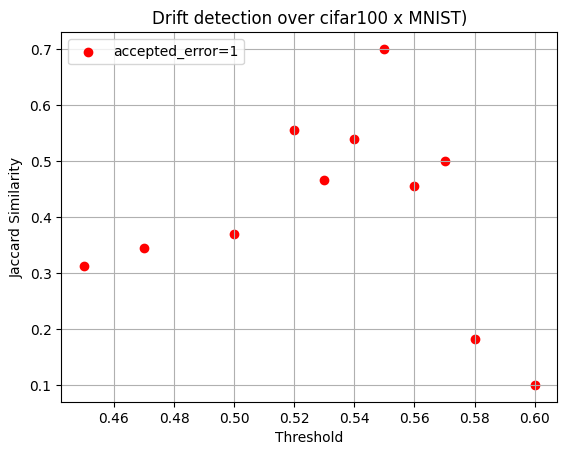

In [17]:
# Perform grid search over the unmasking algorithm.
thresholds = [0.45, 0.47, 0.5, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.6]
jaccard_sim_unm = []

print("Unmasking:")
for thr in thresholds:
    print(f"Threshold = {thr}")
    sim_unm = detect_drifts(data_splitted, unm.drift_detector, ground_truth_drifts_batch, show_drifts=False, accepted_error=1, threshold=thr, min_feature_percentage_remaining=0.05)
    print(sim_unm)
    jaccard_sim_unm.append(sim_unm)


# Plot the results
plt.xlabel('Threshold')
plt.ylabel('Jaccard Similarity')
plt.title('Drift detection over cifar100 x MNIST)')

plt.scatter(thresholds, jaccard_sim_unm, marker='o', color='red', label='accepted_error=1')
plt.grid()
plt.legend()
# plt.savefig('/home/edstan/Desktop/master_AI/practice/images/svhn_itself_jaccard_thresholds_error1.png')
plt.show()

In [20]:
print("D3:")
sim_d3 = detect_drifts(data_splitted, d3.drift_detector, ground_truth_drifts_batch, accepted_error=1, show_drifts=False)
print(sim_d3)

D3:
0.5
